## Modelbuilder
This notebook presents the basic features of the modelbuilder proof of concept. It generates a D-Flow Flexible Mesh model from scratch with only a lat/lon box as input. However, when using it without Deltares P-drive connection the GEBCO bathymetry dataset is only available for the two example cases Bonaire and Vietnam. Also, the tidal models are not all available online. Since this is a proof of concept, many functions/inputs will change in the future but this notebook will be updated accordingly.

A more advanced example of model building is available at: 
https://github.com/Deltares/dfm_tools/blob/main/tests/examples_workinprogress/workinprogress_modelbuilder.py


In [1]:
# import packages
import os
import matplotlib.pyplot as plt
plt.close('all')
import dfm_tools as dfmt
from dfm_tools import modelbuilder as mb
import hydrolib.core.dflowfm as hcdfm
import xarray as xr
import pandas as pd
import numpy as np
import contextily as ctx


In [2]:
# user input
model_name = 'Vietnam'
dir_output = os.path.abspath(f'./{model_name}_model')
# path_style = 'windows' # windows / unix
overwrite = False # used for downloading of forcing data. Always set to True when changing the domain
is_geographic = True # spherical (True) or cartesian (False) coordinates
crs = 'EPSG:4326' # coordinate reference system

# domain and resolution
if model_name=='Bonaire':
    lon_min, lon_max, lat_min, lat_max = -68.55, -67.9, 11.8, 12.6
    dxy = 0.05
    buffer = 0.01
elif model_name=='Vietnam':
    lon_min, lon_max, lat_min, lat_max = 105.8, 106.85, 17.75, 18.5
    dxy = 0.05
    buffer = 0.17 # 0.06 for CMEMS, 0.12 for EOT20, 0.17 for tpxo80

#dates as understood by pandas.period_range(). ERA5 has freq='M' (month) and CMEMS has freq='D' (day)
date_min = '2022-11-01'
date_max = '2022-11-03'
ref_date = '2022-01-01'


In [3]:
# make directories and list all files
os.makedirs(dir_output, exist_ok=True)
dir_output_data = os.path.join(dir_output, 'data')
os.makedirs(dir_output_data, exist_ok=True)
os.listdir(dir_output)

['data']

## Grid generation and refinement with meshkernelpy

Another notebook with more grid generation details exposed (at the MeshkernelPy Github): https://github.com/Deltares/MeshKernelPy/blob/main/docs/examples/06_mesh2d_refinement_gridded_samples_gebco.ipynb

Another more advanced example of grid generation is available at: 
https://github.com/Deltares/dfm_tools/blob/main/tests/examples_workinprogress/workinprogress_meshkernel_creategrid.py


>> reading coastlines: 0.77 sec
>> reading coastlines: 0.54 sec


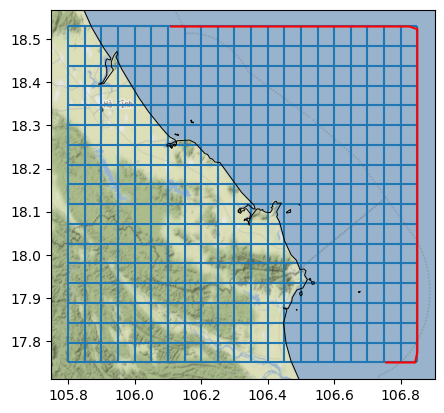

In [4]:
# generate spherical regular grid
mk_object = dfmt.make_basegrid(lon_min, lon_max, lat_min, lat_max, dx=dxy, dy=dxy, is_geographic=is_geographic)

# generate plifile from grid extent and coastlines
bnd_gdf = dfmt.generate_bndpli_cutland(mk=mk_object, res='h', buffer=buffer)
bnd_gdf['name'] = f'{model_name}_bnd'
bnd_gdf_interp = dfmt.interpolate_bndpli(bnd_gdf,res=0.03)
poly_file = os.path.join(dir_output, f'{model_name}.pli')
pli_polyfile = dfmt.geodataframe_to_PolyFile(bnd_gdf_interp)
pli_polyfile.save(poly_file)

# plot basegrid and polyline
fig, ax = plt.subplots()
mk_object.mesh2d_get().plot_edges(ax,zorder=1)
bnd_gdf_interp.plot(ax=ax, edgecolor='r')
ctx.add_basemap(ax=ax, crs=crs, attribution=False)
dfmt.plot_coastlines(ax=ax, crs=crs)


>> reading coastlines: 0.54 sec


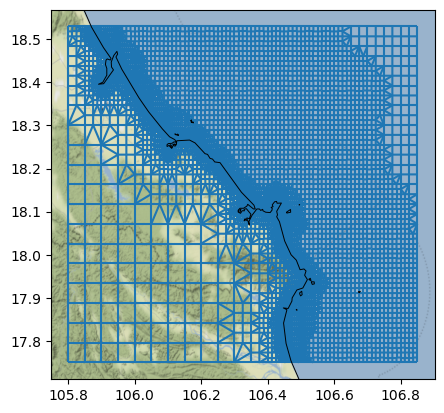

In [5]:
# connect to an example cutout of the GEBCO_2021 dataset on OPeNDAP
# alternatively download your own cutout from https://download.gebco.net (use a buffer of e.g. 1 degree)
file_gebco = f'https://opendap.deltares.nl/thredds/dodsC/opendap/deltares/Delft3D/netcdf_example_files/GEBCO_2021_cutouts/GEBCO_2021_{model_name}.nc'
data_bathy_sel = xr.open_dataset(file_gebco)

# refine grid
min_edge_size = 300 #in meters
dfmt.refine_basegrid(mk=mk_object, data_bathy_sel=data_bathy_sel, min_edge_size=min_edge_size)

# plot
fig, ax = plt.subplots()
mk_object.mesh2d_get().plot_edges(ax,zorder=1)
ctx.add_basemap(ax=ax, crs=crs, attribution=False)
dfmt.plot_coastlines(ax=ax, crs=crs)


>> reading coastlines: 0.65 sec
>> reading coastlines: 0.54 sec


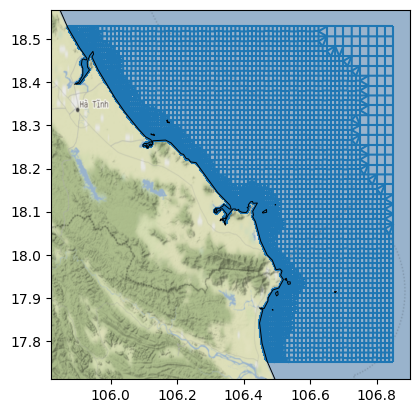

In [6]:
# remove land with GSHHS coastlines
dfmt.meshkernel_delete_withcoastlines(mk=mk_object, res='h')

# plot
fig, ax = plt.subplots()
mk_object.mesh2d_get().plot_edges(ax,zorder=1)
ctx.add_basemap(ax=ax, crs=crs, attribution=False)
dfmt.plot_coastlines(ax=ax, crs=crs)


>> reading coastlines: 0.90 sec


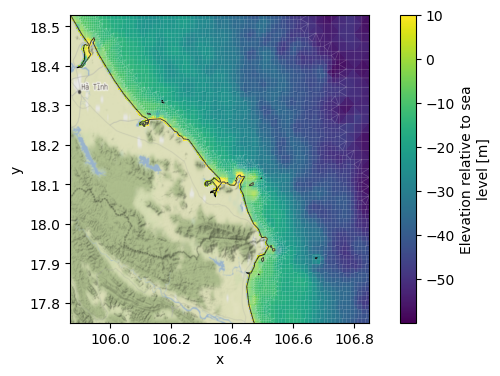

In [7]:
# convert to xugrid
xu_grid_uds = dfmt.meshkernel_to_UgridDataset(mk=mk_object, crs=crs)

# interpolate bathymetry onto the grid
data_bathy_interp = data_bathy_sel.interp(lon=xu_grid_uds.obj.mesh2d_node_x, lat=xu_grid_uds.obj.mesh2d_node_y).reset_coords(['lat','lon'])
xu_grid_uds['mesh2d_node_z'] = data_bathy_interp.elevation.clip(max=10)

# plot bathymetry and grid
fig, ax = plt.subplots(figsize=(8,4))
xu_grid_uds.mesh2d_node_z.ugrid.plot(ax=ax,center=False)
xu_grid_uds.grid.plot(ax=ax,linewidth=0.5,color='white',alpha=0.2)
ctx.add_basemap(ax=ax, crs=crs, attribution=False)
dfmt.plot_coastlines(ax=ax, crs=crs)

# write xugrid grid to netcdf
netfile = os.path.join(dir_output, f'{model_name}_net.nc')
xu_grid_uds.ugrid.to_netcdf(netfile)


## Generate boundary conditions from tidal model and CMEMS (new format .ext)

In [8]:
# generate new format external forcings file (.ext): initial and open boundary condition
ext_file_new = os.path.join(dir_output, f'{model_name}_new.ext')
ext_new = hcdfm.ExtModel()


In [9]:
# interpolate tidal components to boundary conditions file (.bc)
tidemodel = 'tpxo80' # tidemodel: FES2014, FES2012, EOT20, GTSM4.1preliminary
ForcingModel_object = dfmt.interpolate_tide_to_bc(tidemodel=tidemodel, file_pli=poly_file, component_list=None)
file_bc_out = os.path.join(dir_output,f'tide_{model_name}_{tidemodel}.bc')
ForcingModel_object.save(filepath=file_bc_out)
boundary_object = hcdfm.Boundary(quantity='waterlevelbnd',
                                 locationfile=poly_file,
                                 forcingfile=ForcingModel_object)
ext_new.boundary.append(boundary_object)


> interp mfdataset to all PolyFile points (lat/lon coordinates)
> actual extraction of data from netcdf with .load() (for 55 plipoints at once, this might take a while)
>>time passed: 0.00 sec
Converting 55 plipoints to hcdfm.ForcingModel(): 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55. >> done in 0.15 sec


In [10]:
# CMEMS - download spatial fields of salinity, temperature, currents and sea surface height
dir_output_data_cmems = os.path.join(dir_output_data, 'cmems')
os.makedirs(dir_output_data_cmems, exist_ok=True)
for varkey in ['so','thetao','uo','vo','zos']:
    dfmt.download_CMEMS(varkey=varkey,
                        longitude_min=lon_min, longitude_max=lon_max, latitude_min=lat_min, latitude_max=lat_max,
                        date_min=date_min, date_max=date_max,
                        dir_output=dir_output_data_cmems, file_prefix='cmems_', overwrite=overwrite)

# CMEMS - boundary conditions file (.bc) and add to ext_bnd
list_quantities = ['waterlevelbnd','salinitybnd','temperaturebnd','uxuyadvectionvelocitybnd']
ext_new = mb.cmems_nc_to_bc(ext_bnd=ext_new,
                            refdate_str=f'minutes since {ref_date} 00:00:00 +00:00',
                            dir_output=dir_output,
                            list_quantities=list_quantities,
                            tstart=date_min,
                            tstop=date_max, 
                            file_pli=poly_file,
                            dir_pattern=os.path.join(dir_output_data_cmems,'cmems_{ncvarname}_*.nc'))

#save new ext file
ext_new.save(filepath=ext_file_new) # ,path_style=path_style)


retrieving time range of CMEMS reanalysis and forecast products
opening pydap connection to opendap dataset and opening with xarray: https://my.cmems-du.eu/thredds/dodsC/cmems_mod_glo_phy_my_0.083_P1D-m.html
found CMEMS credentials
opening pydap connection to opendap dataset and opening with xarray: https://nrt.cmems-du.eu/thredds/dodsC/cmems_mod_glo_phy_anfc_0.083deg_P1D-m.html
The CMEMS 'analysisforecast' product will be used.
opening pydap connection to opendap dataset and opening with xarray: https://nrt.cmems-du.eu/thredds/dodsC/cmems_mod_glo_phy-so_anfc_0.083deg_P1D-m.html
xarray subsetting data (variable 'so' and lon/lat extents)
available time range in dataset from 2020-11-01 12:00:00 to 2023-09-24 12:00:00
xarray subsetting data per <Day>: 2022-10-31
xarray writing netcdf file: cmems_so_2022-10-31.nc
xarray subsetting data per <Day>: 2022-11-01
xarray writing netcdf file: cmems_so_2022-11-01.nc
xarray subsetting data per <Day>: 2022-11-02
xarray writing netcdf file: cmems_so_2

>> reading coastlines: 0.85 sec
>> reading coastlines: 0.84 sec


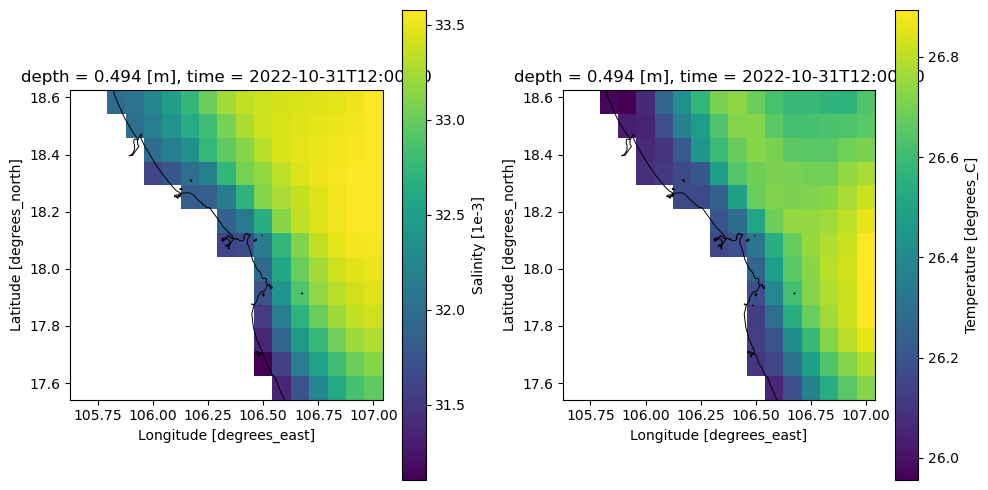

In [11]:
# plot downloaded CMEMS data
file_cmems = os.path.join(dir_output_data,'cmems','*.nc')
ds_cmems = xr.open_mfdataset(file_cmems)
ds_cmems

# plot
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(10,5))
ds_cmems.so.isel(time=0,depth=0).plot(ax=ax1)
dfmt.plot_coastlines(ax=ax1, crs=crs)
ds_cmems.thetao.isel(time=0,depth=0).plot(ax=ax2)
dfmt.plot_coastlines(ax=ax2, crs=crs)
fig.tight_layout()


(-59.95967006784452, 0.02965003252029419)

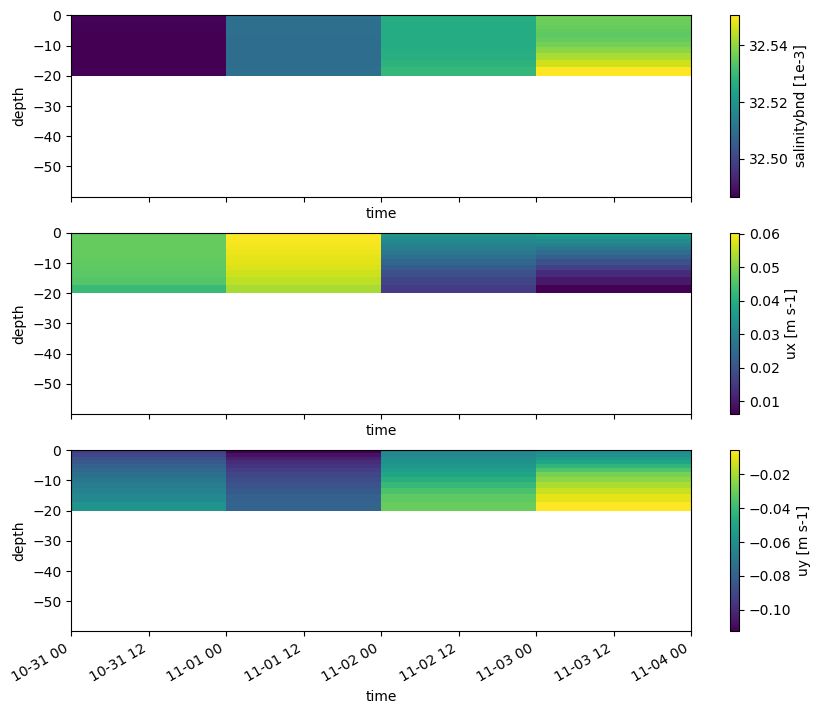

In [12]:
# plot interpolated CMEMS data (boundary conditions in .bc)
file_bc_sal = os.path.join(dir_output,f'salinitybnd_{model_name}_CMEMS.bc')
bc_obj_sal = hcdfm.ForcingModel(file_bc_sal)
forcing_xr_sal = dfmt.forcinglike_to_Dataset(bc_obj_sal.forcing[0], convertnan=True)

file_bc_uxuy = os.path.join(dir_output,f'uxuyadvectionvelocitybnd_{model_name}_CMEMS.bc')
bc_obj_uxuy = hcdfm.ForcingModel(file_bc_uxuy)
forcing_xr_uxuy = dfmt.forcinglike_to_Dataset(bc_obj_uxuy.forcing[0], convertnan=True)

# plot
fig, (ax1,ax2,ax3) = plt.subplots(3,1,sharex=True,sharey=True,figsize=(10,8))
forcing_xr_sal['salinitybnd'].T.plot(ax=ax1)
forcing_xr_uxuy['ux'].T.plot(ax=ax2)
forcing_xr_uxuy['uy'].T.plot(ax=ax3)
ax1.set_ylim(xu_grid_uds.mesh2d_node_z.min(),None)

## Generate ERA5 meteo forcing (old ext)

In [13]:
# generate old format external forcings file (.ext): spatial data
ext_file_old = os.path.join(dir_output, f'{model_name}_old.ext')
ext_old = hcdfm.ExtOldModel()

# ERA5 - download spatial fields of air pressure, wind speeds and Charnock coefficient
dir_output_data_era5 = os.path.join(dir_output_data,'ERA5')
os.makedirs(dir_output_data_era5, exist_ok=True)
    
varlist_list = [['msl','u10n','v10n','chnk']]

for varlist in varlist_list:
    for varkey in varlist:
        dfmt.download_ERA5(varkey, 
                           longitude_min=lon_min, longitude_max=lon_max, latitude_min=lat_min, latitude_max=lat_max,
                           date_min=date_min, date_max=date_max,
                           dir_output=dir_output_data_era5, overwrite=overwrite)

# ERA5 meteo - convert to netCDF for usage in Delft3D FM
ext_old = mb.preprocess_merge_meteofiles_era5(ext_old=ext_old,
                                              varkey_list = varlist_list,
                                              dir_data = dir_output_data_era5,
                                              dir_output = dir_output,
                                              time_slice = slice(date_min, date_max))

ext_old.save(filepath=ext_file_old) # ,path_style=path_style)


found CDS apikey
retrieving data from 2022-11 to 2022-11 (freq=<MonthEnd>)
retrieving ERA5 data for variable "msl" and month 2022-11 (YYYY-MM)


2023-09-15 14:55:54,611 INFO Welcome to the CDS
2023-09-15 14:55:54,612 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-single-levels
2023-09-15 14:55:54,872 INFO Request is completed
2023-09-15 14:55:54,872 INFO Downloading https://download-0018.copernicus-climate.eu/cache-compute-0018/cache/data4/adaptor.mars.internal-1694768900.4953644-31601-2-f777c0f7-81f6-412c-b098-5e6ae3625db0.nc to c:\Users\laan_st\Downloads\aNewSpring\Exercises_clean\Ex11_python_pre-processing\Vietnam_model\data\ERA5\era5_msl_2022-11.nc (63K)
2023-09-15 14:55:55,415 INFO Download rate 116.1K/s                                                                                                                                                 
2023-09-15 14:55:55,510 INFO Welcome to the CDS
2023-09-15 14:55:55,510 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-single-levels


found CDS apikey
retrieving data from 2022-11 to 2022-11 (freq=<MonthEnd>)
retrieving ERA5 data for variable "u10n" and month 2022-11 (YYYY-MM)


2023-09-15 14:55:55,730 INFO Request is completed
2023-09-15 14:55:55,732 INFO Downloading https://download-0011-clone.copernicus-climate.eu/cache-compute-0011/cache/data8/adaptor.mars.internal-1694769029.6677403-15133-14-b719c1bf-83cd-4592-a369-920d3d68f6cc.nc to c:\Users\laan_st\Downloads\aNewSpring\Exercises_clean\Ex11_python_pre-processing\Vietnam_model\data\ERA5\era5_u10n_2022-11.nc (63K)
2023-09-15 14:55:56,264 INFO Download rate 118.8K/s                                                                                                                                                 
2023-09-15 14:55:56,359 INFO Welcome to the CDS
2023-09-15 14:55:56,362 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-single-levels


found CDS apikey
retrieving data from 2022-11 to 2022-11 (freq=<MonthEnd>)
retrieving ERA5 data for variable "v10n" and month 2022-11 (YYYY-MM)


2023-09-15 14:55:56,559 INFO Request is completed
2023-09-15 14:55:56,562 INFO Downloading https://download-0011-clone.copernicus-climate.eu/cache-compute-0011/cache/data5/adaptor.mars.internal-1694769118.7747822-21116-5-31d20a2e-6058-40d9-815f-9a02d131e123.nc to c:\Users\laan_st\Downloads\aNewSpring\Exercises_clean\Ex11_python_pre-processing\Vietnam_model\data\ERA5\era5_v10n_2022-11.nc (63K)
2023-09-15 14:55:56,647 INFO Download rate 759.6K/s                                                                                                                                                 
2023-09-15 14:55:56,749 INFO Welcome to the CDS
2023-09-15 14:55:56,752 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-single-levels


found CDS apikey
retrieving data from 2022-11 to 2022-11 (freq=<MonthEnd>)
retrieving ERA5 data for variable "chnk" and month 2022-11 (YYYY-MM)


2023-09-15 14:55:56,947 INFO Request is completed
2023-09-15 14:55:56,948 INFO Downloading https://download-0006-clone.copernicus-climate.eu/cache-compute-0006/cache/data4/adaptor.mars.internal-1694769174.3089287-13940-5-ccd4e99a-c72b-4251-8e2b-29565d9dd3ae.nc to c:\Users\laan_st\Downloads\aNewSpring\Exercises_clean\Ex11_python_pre-processing\Vietnam_model\data\ERA5\era5_chnk_2022-11.nc (63K)
2023-09-15 14:55:57,501 INFO Download rate 114.2K/s                                                                                                                                                 


>> opening multifile dataset of 4 files (can take a while with lots of files): 0.05 sec
>> writing file (can take a while): 0.62 sec


>> reading coastlines: 0.96 sec
>> reading coastlines: 0.86 sec


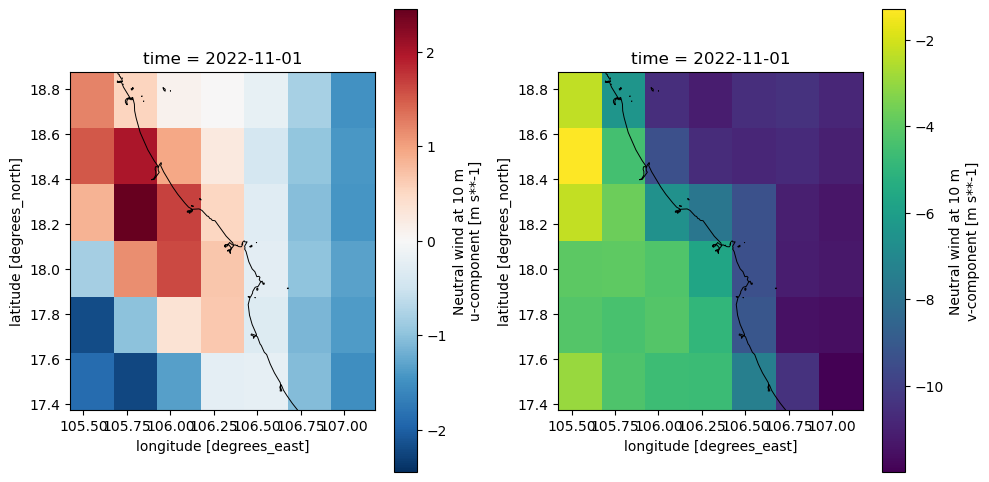

In [14]:
# plot converted ERA5 data
file_era5 = os.path.join(dir_output,'data','ERA5','*.nc')
ds_era5 = xr.open_mfdataset(file_era5)
ds_era5

# plot
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(10,5))
ds_era5.u10n.isel(time=0).plot(ax=ax1)
dfmt.plot_coastlines(ax=ax1, crs=crs)
ds_era5.v10n.isel(time=0).plot(ax=ax2)
dfmt.plot_coastlines(ax=ax2, crs=crs)
fig.tight_layout()


## Generate obsfile

               x          y            name
5077  106.107813  18.256687  x106p11_y18p26
4141  106.460938  18.047418  x106p46_y18p05
6768  106.242188  18.236636  x106p24_y18p24
6841  106.482813  17.757192  x106p48_y17p76
4917  106.040626  18.401203  x106p04_y18p40
1816  106.606250  17.824791  x106p61_y17p82
5382  106.460939  17.826229  x106p46_y17p83
1195  106.543750  18.031635  x106p54_y18p03
732   106.302084  18.191274  x106p30_y18p19
5081  106.204688  18.256687  x106p20_y18p26
>> reading coastlines: 0.86 sec


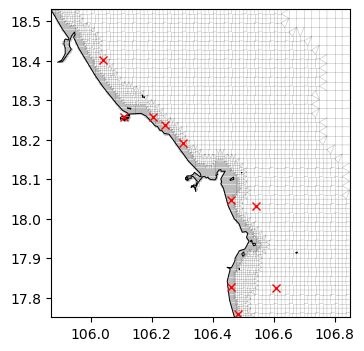

In [15]:
# generate obspoints on all grid faces
xpts = xu_grid_uds.grid.face_x
ypts = xu_grid_uds.grid.face_y
npts = [f'x{x:.2f}_y{y:.2f}'.replace('.','p') for x,y in zip(xpts,ypts)]
obs_pd = pd.DataFrame(dict(x=xpts,y=ypts,name=npts))

# subselect n arbitary obspoints and plot
n = 10
ipts = np.random.randint(0, len(obs_pd), n)
obs_pd = obs_pd.iloc[ipts]
print(obs_pd)
fig, ax = plt.subplots(figsize=(8,4))
xu_grid_uds.grid.plot(ax=ax,linewidth=0.5,color='k',alpha=0.2)
ax.plot(obs_pd['x'],obs_pd['y'],'rx')
dfmt.plot_coastlines(ax=ax, crs=crs)

# save obsfile
file_obs = os.path.join(dir_output, f'{model_name}_obs.xyn')
obs_pd.to_csv(file_obs, sep=' ', header=False, index=False, float_format='%.6f')


## Generate mdu file

In [16]:
# initialize mdu file and update settings
mdu_file = os.path.join(dir_output, f'{model_name}.mdu')
mdu = hcdfm.FMModel()

# add the grid (_net.nc, network file)
mdu.geometry.netfile = netfile

# add the external forcing files (.ext)
mdu.external_forcing.extforcefile = ext_file_old
mdu.external_forcing.extforcefilenew = ext_new

# update time settings
mdu.time.refdate = pd.Timestamp(ref_date).strftime('%Y%m%d')
mdu.time.tunit = 'S'
mdu.time.dtmax = 30
mdu.time.startdatetime = pd.Timestamp(date_min).strftime('%Y%m%d%H%M%S')
mdu.time.stopdatetime = pd.Timestamp(date_max).strftime('%Y%m%d%H%M%S')
mdu.time.autotimestep = 3

# update output settings
mdu.output.obsfile = file_obs
mdu.output.hisinterval = [60]
mdu.output.mapinterval = [1800]#[86400]
mdu.output.rstinterval = [0]
mdu.output.statsinterval = [3600]

# save .mdu file
mdu.save(mdu_file) # ,path_style=path_style)


## Generate DIMR and bat file

In [17]:
from hydrolib.core.dimr.models import DIMR, FMComponent, Start
mdu_name = os.path.basename(mdu_file)
nproc = 1 # hydrolib-core does not support multiple cores: https://github.com/Deltares/dfm_tools/issues/214

# generate dimr_config.xml
control_comp = Start(name=model_name)
fm_comp = FMComponent(name=model_name, workingDir='.', inputfile=mdu_name,
                      # process=nproc, 
                      mpiCommunicator="DFM_COMM_DFMWORLD")
dimr_model = DIMR(control=control_comp, component=fm_comp)
dimr_file = os.path.join(dir_output,'dimr_config.xml')
dimr_model.save(dimr_file)

# generate bat file for running on windows
bat_str = fr"""
rem User input
set D3D_folder="c:\Program Files\Deltares\Delft3D FM Suite 2023.02 HMWQ"
set MDU_file={mdu_name}
set partitions={nproc}

rem Partition the network and mdu
call %D3D_folder%\plugins\DeltaShell.Dimr\kernels\x64\dflowfm\scripts\run_dflowfm.bat "--partition:ndomains=%partitions%:icgsolver=6" %MDU_file%

rem Execute the simulation
call %D3D_folder%\plugins\DeltaShell.Dimr\kernels\x64\dimr\scripts\run_dimr_parallel.bat %partitions% {os.path.basename(dimr_file)}

rem To prevent the DOS box from disappearing immediately: enable pause on the following line
pause
"""
bat_file = os.path.join(dir_output,"run_parallel.bat")
with open(bat_file,'w') as f:
    f.write(bat_str)


## Check written files in model directory

In [18]:
# list all files
os.listdir(dir_output)

['data',
 'dimr_config.xml',
 'era5_msl_u10n_v10n_chnk_20221101to20221103_ERA5.nc',
 'run_parallel.bat',
 'salinitybnd_Vietnam_CMEMS.bc',
 'temperaturebnd_Vietnam_CMEMS.bc',
 'tide_Vietnam_tpxo80.bc',
 'uxuyadvectionvelocitybnd_Vietnam_CMEMS.bc',
 'Vietnam.mdu',
 'Vietnam.pli',
 'Vietnam_net.nc',
 'Vietnam_new.ext',
 'Vietnam_obs.xyn',
 'Vietnam_old.ext',
 'waterlevelbnd_Vietnam_CMEMS.bc']

# Exercises

After running the model generated above, the postprocessing notebook can be used to visualize your his and map output. Additionally, you can change the model input above and rerun the model builder and the model. It might be useful to check the [D-Flow FM manual](https://content.oss.deltares.nl/delft3d/D-Flow_FM_User_Manual.pdf) for background information. Some suggestions for model changes:
- change/extend the model simulation period
- apply more/less refinement to the grid
- the observation points are randomly generated, add obspoints near actual cities/harbours/islands instead
- add a observation cross-section near a harbour or river
- add river inflow as a boundary condition (.pli and .bc in new format .ext or .pli and .tim in old format .ext)
- convert this 2D model into a 3D model
- enable the computation of salinity and temperature in the mdu (salinity=1 and temperature=5)
- use the fourier smoothing time (tlfSmo) to make the model spinup less chaotic
- try decreasing/increasing the buffer for the boundary pli. It is currently quite large for Vietnam since the used tide dataset lacks coverage near the coast.
